### 이 notebook은 RNNConv 모델을 구현한 방법 및 모델 구성에 대해 설명합니다.
논문에서 여러 아키텍쳐에 대한 실험을 진행한 결과, 두 데이터셋(32 X 32 Dataset, High Entorpy Dataset)에서 실험 한 결과, 평균적으로 제일 좋은 성능을 보여주었다고 할 수 있는 GRU-OneShot 모델에 대해서만 구현할 것이고, 이 모델들에 대한 분석을 진행한다.

#### 1. GRUConv
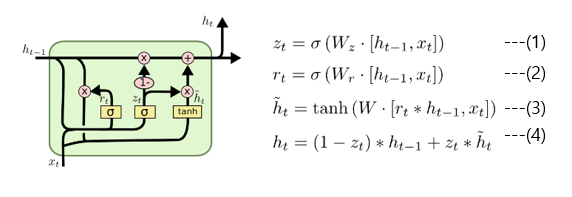

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair

In [ ]:
class ConvGRUCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size=3, stride=1, padding=0, dilation=1, hidden_kernel_size=1, bias=True):
        super(ConvGRUCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.dilation = _pair(dilation)

        self.hidden_kernel_size = _pair(hidden_kernel_size)

        hidden_padding = _pair(hidden_kernel_size // 2)

        #gate_channels = 4 * self.hidden_channels

        self.conv_ih = nn.Conv2d(
            in_channels=self.input_channels,
            out_channels= 3 * self.hidden_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            bias=bias)

        self.conv_hh = nn.Conv2d(
            in_channels=self.hidden_channels,
            out_channels= 2 * self.hidden_channels,
            kernel_size=hidden_kernel_size,
            stride=1,
            padding=hidden_padding,
            dilation=1,
            bias=bias)
        
        self.conv_u = nn.Conv2d(
            in_channels=self.hidden_channels,
            out_channels=self.hidden_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            dilation=1,
            bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.conv_ih.reset_parameters()
        self.conv_hh.reset_parameters()
        self.conv_u.reset_parameters()

    def forward(self, input, hidden):
        gate_x = self.conv_ih(input)
        gate_h = self.conv_hh(hidden)

        x_r, x_i, x_u = gate_x.chunk(3, 1)
        h_r, h_i = gate_h.chunk(2, 1)

        r_t = F.sigmoid(x_r + h_r)
        z_t = F.sigmoid(x_i + h_i)

        h_tilde_y = F.tanh(x_u + self.conv_u((r_t * hidden)))
        hy = (1 - z_t) * hidden + z_t * h_tilde_y
        
        return hy